In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchviz import make_dot


In [2]:


manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)


In [3]:
torch.cuda.set_device(1)
print(torch.cuda.current_device())

1


In [4]:
##Hyperparameters

#Root directory
dataroot = "/path/to/data/folder"

model_path = "/path/to/store/model"

#Num workers for data laoder
workers = 2

#Batch size 
batch_size = 64

#Image size
image_size = 112 #In the tutorial this is 64. Watch out the structures

#Channels
nc = 3 #or 1

#Size of z latent vector i.e generator input 
nz=20000

#Size of feature maps in generator
ngf = 32

#Size of feature maps in discriminator
ndf = 32

lr = 0.0002 

beta1 = 0.5 #For adam optimizer
ngpu = 1 #0 to train in CPU

num_epochs = 2200

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0) else "cpu")

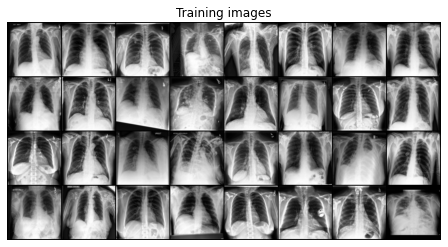

In [5]:
dataset  = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #If 3 channels then each bracket has 3 values, one for each channel
]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)



#Plotting some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32],padding=2,normalize=True).cpu(),(1,2,0)))

In [6]:
for data in dataloader:
    print(data[0][0].shape)
    #print(data[1])
    break


torch.Size([3, 112, 112])


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
#Generator

class Generator(nn.Module):
    def __init__(self,ngpu=1,latent_dim = 20000):
        self.ngpu = ngpu
        self.latent_dim = latent_dim
        super(Generator,self).__init__()

        self.NoiseBranch = nn.Sequential(
            #Takes the noise 
            nn.Linear(in_features=self.latent_dim,out_features=1024*7*7,bias=False),
            nn.ReLU(),
            nn.Unflatten(1,(1024,7,7)) #changed 0 to 1
        )

        self.LabelBranch = nn.Sequential(
            nn.Embedding(50,1),
            nn.Linear(in_features=1,out_features=49,bias=False),
            nn.Unflatten(1,(1,7,7))
            

        )

        from functools import reduce
        from operator import __add__
        k=5 #Kernel size
        #conv_padding = reduce(__add__,(k//2+(k-2*(k//2))-1,k//2))

        self.main = nn.Sequential(
            #Takes main model

                  
            nn.ConvTranspose2d(1025,ngf*16,5,2, padding=2, output_padding=1, bias=False), #512
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True), #Size batch_size*512*14*14
            
            
            nn.ConvTranspose2d(ngf*16,ngf*8,5,2,padding=2, output_padding=1, bias=False), #256
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True), #Size BS*256*28*28

            
            nn.ConvTranspose2d(ngf*8,ngf*4,5,2, padding=2, output_padding=1,bias=False), #128
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True), #Size BS*128*56*56

            
            nn.ConvTranspose2d(ngf*4,3,5,2,padding=2, output_padding=1,bias=False),
            nn.Tanh() #Size BS*3*112*112

            
        )
    def forward(self,label,noise):
        noise_branch = self.NoiseBranch(noise)
        label_branch = self.LabelBranch(label)
        #label_branch2 = torch.squeeze(label_branch,dim=0)       
        #print(noise_branch.shape,label_branch.shape)

        combined = torch.cat((noise_branch,label_branch),dim=1)        
        #return combined.shape #1025*7*7 shape
        #combined = torch.unsqueeze(combined,0) #Change this when passing batches
        return self.main(combined)

In [10]:
#Create generator
netG = Generator(ngpu,latent_dim=nz).to(device)

if(device.type=='cuda') and (ngpu>1):
    netG = nn.DataParallel(netG,list(range(ngpu)))

netG.apply(weights_init)
#print(netG)

Generator(
  (NoiseBranch): Sequential(
    (0): Linear(in_features=20000, out_features=50176, bias=False)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(1024, 7, 7))
  )
  (LabelBranch): Sequential(
    (0): Embedding(50, 1)
    (1): Linear(in_features=1, out_features=49, bias=False)
    (2): Unflatten(dim=1, unflattened_size=(1, 7, 7))
  )
  (main): Sequential(
    (0): ConvTranspose2d(1025, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): BatchNorm2d(

In [11]:
class Discriminator(nn.Module):    
    def __init__(self,ngpu=1):
        self.ngpu = ngpu 
        super(Discriminator,self).__init__()
        k = 3 #Kernel size
        from functools import reduce
        from operator import __add__
        conv_padding = reduce(__add__,(k//2+(k-2*(k//2))-1,k//2))
        self.main = nn.Sequential(
            #Z is going into a conv 
            nn.ZeroPad2d(conv_padding),
            nn.Conv2d(nc,ndf,3,1,bias=False),
            nn.BatchNorm2d(ndf),            
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(p=0.5),
            
            nn.ZeroPad2d(conv_padding),
            nn.Conv2d(ndf,ndf*2,3,2,bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(p=0.5),

            nn.ZeroPad2d(conv_padding),
            nn.Conv2d(ndf*2,ndf*4,3,2,bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(p=0.5),

            nn.ZeroPad2d(conv_padding),
            nn.Conv2d(ndf*4,ndf*8,3,2,bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(p=0.5),

            nn.ZeroPad2d(conv_padding),
            nn.Conv2d(ndf*8,ndf*16,3,2,bias=False),
            nn.BatchNorm2d(ndf*16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(p=0.5),

            
            nn.Flatten(), 
            #Size after flatten is 51200
            
        )
        self.dense_val = nn.Linear(41472,1,bias=False)
        self.dense_label = nn.Linear(41472,2,bias=False)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input):
        #return self.main(input)
        init_branch = self.main(input)
        validity = self.dense_val(init_branch)
        validity = self.sigmoid(validity)
        label = self.dense_label(init_branch)
        label = self.softmax(label)
        return (validity,label)


In [12]:
#Create discriminator
netD = Discriminator(ngpu).to(device)

if device.type=='cuda' and ngpu>1:
    netD = nn.DataParallel(netD,list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): ZeroPad2d(padding=(2, 2, 2, 2), val

In [13]:
#Init loss and optim
criterian_source = nn.BCELoss()
criterian_label = nn.CrossEntropyLoss()

#Creating a batch of latent vectors to visualize the progression of generator

#fixed_noise = torch.randn(20000,nz,1,1,device=device,requires_grad=True)
eval_noise = np.random.normal(0,1,(batch_size,nz))
eval_label = np.random.randint(0,2,batch_size)

eval_noise = ((torch.from_numpy(eval_noise))).float()
eval_noise = eval_noise.to(device)

eval_label = ((torch.from_numpy(eval_label))).long()
eval_label = eval_label.to(device)


real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr,betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr,betas=(beta1,0.999))

In [14]:
def compute_acc(preds,labels):
    correct=0
    preds_ = preds.data.max(1)[1]
    correct = preds_.eq(labels.data).cpu().sum()
    acc = float(correct)/float(len(labels.data)) * 100.0
    return acc

In [15]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
#Training loop complete implementation
print("Starting training loop")

#img_list = []
G_losses = []
D_losses = []
iters=0
real_label = torch.FloatTensor(batch_size).to(device)
real_label.fill_(1)

fake_label = torch.FloatTensor(batch_size).to(device)
fake_label.fill_(0)



for epoch in range(num_epochs):
    print('Epoch {} of {}'.format(epoch + 1, num_epochs))
    G_loss =0
    D_loss=0
    for i,data in enumerate(dataloader,0):
        optimizerD.zero_grad()

        #Training with real data
        curr_batch_size = len(data[1])    

        real_label = torch.FloatTensor(curr_batch_size).to(device)
        real_label.fill_(1)

        fake_label = torch.FloatTensor(curr_batch_size).to(device)
        fake_label.fill_(0)    

        image,label = data
        image,label = image.to(device), label.to(device)
        source_,class_ = netD(image) #Feed real images first
        source_error_real = criterian_source(source_,real_label.unsqueeze(1))
        class_error_real = criterian_label(class_,label)
        error_real = source_error_real+class_error_real
        error_real.backward()
        optimizerD.step()

        accuracy = compute_acc(class_,label) #Currect classification accuracy

        #Training with fake data
        noise_ = np.random.normal(0,1,(curr_batch_size,nz))
        label = np.random.randint(0,2,curr_batch_size)
        
        noise = ((torch.from_numpy(noise_))).float()
        noise = noise.to(device)

        label = ((torch.from_numpy(label))).long()
        label = label.to(device)

        noise_img = netG(label,noise)       
        

        source_,class_ = netD(noise_img.detach())

        source_error_fake = criterian_source(source_,fake_label.unsqueeze(1))
        class_error_fake = criterian_label(class_,label)
        error_fake = source_error_fake+class_error_fake
        error_fake.backward()
        optimizerD.step()
        D_loss+=error_fake + error_real
        

        #Training the generator
        netG.zero_grad()
        source_,class_=netD(noise_img)
        source_error = criterian_source(source_,real_label.unsqueeze(1))
        class_error = criterian_label(class_,label)
        error_gen = source_error+class_error
        error_gen.backward()
        optimizerG.step()
        
        iters+=1
        G_loss+=error_gen

        if i%100==0:
            print("Epoch--[{} / {}], Loss_Discriminator--[{}], Loss_Generator--[{}], accuracy--[{}%]".format(epoch+1,num_epochs,error_fake+error_real,error_gen, accuracy))
            writer.add_scalar('100BatchLoss/Disc/Source',source_error_fake+source_error_real,epoch+1)
            writer.add_scalar('100BatchLoss/Disc/Class',class_error_fake+class_error_real,epoch+1)
            writer.add_scalar('100BatchLoss/Gen',error_gen,epoch+1)
            writer.add_scalar('100BatchLoss/Accuracy',accuracy,epoch+1)

            constructed = netG(eval_label,eval_noise)  
            #writer.add_image('Consturcted Images',constructed.data)          

            vutils.save_image(
                constructed.data,
                'images/result_epoch%03d.png'%(epoch)
            )
    
    tot_epoch_disc = D_loss/len(dataloader)
    tot_epoch_gen = G_loss/len(dataloader)

    

    writer.add_scalar('EpochGenLoss/train',tot_epoch_gen.data,epoch+1)
    writer.add_scalar('EpochDiscLoss/train',tot_epoch_disc.data,epoch+1)

    print("Total mean epoch losses")
    print("Epoch--[{} / {}], Loss_Discriminator--[{}], Loss_Generator--[{}]".format(epoch+1,num_epochs,tot_epoch_disc,tot_epoch_gen))
    D_losses.append(tot_epoch_disc.data)
    G_losses.append(tot_epoch_gen.data)

    
    
    
    path = model_path+str(epoch)+'_'+str(tot_epoch_gen.data)+'.pt'
    state = {
        'neG': netG.state_dict(),
        'gen_loss':tot_epoch_gen

    }
    
    if epoch%100==0:
        path = model_path+str(epoch)+'_'+str(tot_epoch_gen.item())+'.pt'
        state={
            'netG':netG.state_dict(),
            'gen_loss':tot_epoch_gen.item()
        }
        torch.save(state,path)


    
    #TODO run for 2200 for covidgan    
    
    

In [ ]:
#Plots
n_d_loss = []

for d in D_losses:
    n_d_loss .append(d.cpu().item())

n_g_loss = []

for g in G_losses:
    n_g_loss .append(g.cpu().item())


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(n_g_loss,label="G")
plt.plot(n_d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()